**helpers**

In [1]:
import numpy as np

# subset of categories that we will use
category_dict = {'comp.graphics': 'computer graphics',
                 'rec.sport.baseball': 'baseball',
                 'sci.electronics': 'science, electronics',
                 'talk.politics.guns': 'politics, guns'
                 }

def get_data(categories=None, portion=1.):
    """
    Get data for given categories and portion
    :param portion: portion of the data to use
    :return:
    """
    # get data
    from sklearn.datasets import fetch_20newsgroups
    data_train = fetch_20newsgroups(categories=categories, subset='train', remove=('headers', 'footers', 'quotes'),
                                    random_state=21)
    data_test = fetch_20newsgroups(categories=categories, subset='test', remove=('headers', 'footers', 'quotes'),
                                   random_state=21)

    # train
    train_len = int(portion*len(data_train.data))
    x_train = np.array(data_train.data[:train_len])
    y_train = data_train.target[:train_len]
    # remove empty entries
    non_empty = x_train != ""
    x_train, y_train = x_train[non_empty].tolist(), y_train[non_empty].tolist()

    # test
    x_test = np.array(data_test.data)
    y_test = data_test.target
    non_empty = np.array(x_test) != ""
    x_test, y_test = x_test[non_empty].tolist(), y_test[non_empty].tolist()
    return x_train, y_train, x_test, y_test

# Q1 and Q2

*imports*

In [2]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

*model definition*

In [3]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=None):
        super(MLPModel, self).__init__()
        if hidden_dim:
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, len(category_dict))
            )
        else:
            self.model = nn.Sequential(
                nn.Linear(input_dim, len(category_dict))
            )

    def forward(self, x):
        return self.model(x)

*Q4 c.*

In [19]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

*training and evaluation*

In [20]:
def MLP_classification(portion=1., model="single"):
    """
    Perform linear classification
    :param portion: portion of the data to use
    :return: classification accuracy
    """
    from sklearn.feature_extraction.text import TfidfVectorizer

    x_train, y_train, x_test, y_test = get_data(categories=category_dict.keys(), portion=portion)

    # TFIDF Vectorization
    vectorizer = TfidfVectorizer(max_features=2000)
    x_train = vectorizer.fit_transform(x_train).toarray()
    x_test = vectorizer.transform(x_test).toarray()

    # Encoding labels
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    # PyTorch Dataset and DataLoader
    train_data = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    test_data = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=16)

    # Model
    input_dim = x_train.shape[1]
    hidden_dim = 500 if model == "multi" else None
    model = MLPModel(input_dim, hidden_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    model_parameters = count_trainable_parameters(model)
    print(f"model={model}, parameters={model_parameters}")


    # print(f"result for model={model}, portion={portion}")

    # Training
    train_losses, test_accuracies = [], []
    for epoch in range(20):
        model.train()
        total_loss = 0
        for x_batch, y_batch in tqdm(train_loader):
            x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluation
        model.eval()
        correct = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
                outputs = model(x_batch)
                predictions = torch.argmax(outputs, dim=1)
                correct += (predictions == y_batch).sum().item()

        accuracy = correct / len(test_data)
        test_accuracies.append(accuracy)

        print()
        print(f"Epoch {epoch + 1}/{20}")
        print(f"Train Loss = {train_loss}")
        print(f"Validation Accuracy = {accuracy}")


    # Plotting
    plt.figure()
    plt.plot(range(1, 21), train_losses, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Train Loss (Portion={portion})")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(1, 21), test_accuracies, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Test Accuracy (Portion={portion})")
    plt.legend()
    plt.show()


# Q3

*installing library*

In [5]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


*functions and class definitions*

In [21]:
def transformer_classification(portion=1.):
    import torch
    from transformers import AutoModelForSequenceClassification, AutoTokenizer
    from torch.utils.data import DataLoader
    import evaluate
    from tqdm import tqdm

    class Dataset(torch.utils.data.Dataset):
        """
        Dataset for loading data
        """
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
            return item

        def __len__(self):
            return len(self.labels)

    def train_epoch(model, data_loader, optimizer, dev='cpu'):
        """
        Perform an epoch of training of the model with the optimizer
        :param model:
        :param data_loader:
        :param optimizer:
        :param dev:
        :return: Average loss over the epoch
        """
        model.train()
        total_loss = 0.
        # iterate over batches
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(dev)
            attention_mask = batch['attention_mask'].to(dev)
            labels = batch['labels'].to(dev)
            ########### add your code here ###########
            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(data_loader)

    def evaluate_model(model, data_loader, dev='cpu', metric=None):
        model.eval()
        for batch in tqdm(data_loader):
          with torch.no_grad():
              input_ids = batch['input_ids'].to(dev)
              attention_mask = batch['attention_mask'].to(dev)
              labels = batch['labels'].to(dev)
              ########### add your code here ###########
              # Forward pass
              outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
              predictions = torch.argmax(outputs.logits, dim=1)

              # Update metric
              metric.add_batch(predictions=predictions, references=labels)
        return metric.compute()

    x_train, y_train, x_test, y_test = get_data(categories=category_dict.keys(), portion=portion)

    # Parameters
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_labels = len(category_dict)
    epochs = 3
    batch_size = 16
    learning_rate = 5e-5

    # Model, tokenizer, and metric
    model = AutoModelForSequenceClassification.from_pretrained('distilroberta-base', num_labels=num_labels).to(dev)
    tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
    metric = evaluate.load("accuracy")

    model_parameters = count_trainable_parameters(model)
    print(f"model={model}, parameters={model_parameters}")

    # Datasets and DataLoaders
    train_dataset = Dataset(tokenizer(x_train, truncation=True, padding=True), y_train)
    val_dataset = Dataset(tokenizer(x_test, truncation=True, padding=True), y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    ########### add your code here ###########
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    train_losses = []
    validation_accuracies = []
    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss = train_epoch(model, train_loader, optimizer, dev=dev)
        print(f"Train Loss: {train_loss:.4f}")

        # Evaluation
        accuracy = evaluate_model(model, val_loader, dev=dev, metric=metric)
        print(f"Validation Accuracy: {accuracy['accuracy']:.4f}")

        train_losses.append(train_loss)
        validation_accuracies.append(next(iter(accuracy.values())))

    # Plotting
    plt.figure()
    plt.plot(range(1, 4), train_losses, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Train Loss (Portion={portion})")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(1, 4), validation_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Validation Accuracy (Portion={portion})")
    plt.legend()
    plt.show()

    return

# MAIN

*where the magic happens*


Single Layer MLP results:
Running Single Layer MLP for Portion=0.1
model=MLPModel(
  (model): Sequential(
    (0): Linear(in_features=2000, out_features=4, bias=True)
  )
), parameters=8004


100%|██████████| 15/15 [00:00<00:00, 436.94it/s]



Epoch 1/20
Train Loss = 1.3831300735473633
Validation Accuracy = 0.3852785145888594


100%|██████████| 15/15 [00:00<00:00, 458.24it/s]



Epoch 2/20
Train Loss = 1.3574663798014324
Validation Accuracy = 0.46419098143236076


100%|██████████| 15/15 [00:00<00:00, 421.57it/s]



Epoch 3/20
Train Loss = 1.3351114829381308
Validation Accuracy = 0.523209549071618


100%|██████████| 15/15 [00:00<00:00, 527.09it/s]



Epoch 4/20
Train Loss = 1.310891580581665
Validation Accuracy = 0.5643236074270557


100%|██████████| 15/15 [00:00<00:00, 465.86it/s]



Epoch 5/20
Train Loss = 1.2900055487950643
Validation Accuracy = 0.5974801061007957


100%|██████████| 15/15 [00:00<00:00, 350.24it/s]



Epoch 6/20
Train Loss = 1.2684059619903565
Validation Accuracy = 0.5994694960212201


100%|██████████| 15/15 [00:00<00:00, 414.79it/s]



Epoch 7/20
Train Loss = 1.2453209320704142
Validation Accuracy = 0.6206896551724138


100%|██████████| 15/15 [00:00<00:00, 438.77it/s]



Epoch 8/20
Train Loss = 1.2258978764216104
Validation Accuracy = 0.6286472148541115


100%|██████████| 15/15 [00:00<00:00, 433.22it/s]



Epoch 9/20
Train Loss = 1.2045629421869914
Validation Accuracy = 0.6319628647214854


100%|██████████| 15/15 [00:00<00:00, 525.08it/s]



Epoch 10/20
Train Loss = 1.185577138264974
Validation Accuracy = 0.6518567639257294


100%|██████████| 15/15 [00:00<00:00, 612.27it/s]



Epoch 11/20
Train Loss = 1.168105411529541
Validation Accuracy = 0.653183023872679


100%|██████████| 15/15 [00:00<00:00, 476.65it/s]



Epoch 12/20
Train Loss = 1.1442916472752889
Validation Accuracy = 0.6618037135278515


100%|██████████| 15/15 [00:00<00:00, 456.61it/s]



Epoch 13/20
Train Loss = 1.1290921290715537
Validation Accuracy = 0.666445623342175


100%|██████████| 15/15 [00:00<00:00, 544.88it/s]



Epoch 14/20
Train Loss = 1.1091626008351645
Validation Accuracy = 0.6684350132625995


100%|██████████| 15/15 [00:00<00:00, 565.72it/s]



Epoch 15/20
Train Loss = 1.0872443914413452
Validation Accuracy = 0.6783819628647215


100%|██████████| 15/15 [00:00<00:00, 448.94it/s]



Epoch 16/20
Train Loss = 1.0690731763839723
Validation Accuracy = 0.6843501326259946


100%|██████████| 15/15 [00:00<00:00, 413.21it/s]



Epoch 17/20
Train Loss = 1.0524125933647155
Validation Accuracy = 0.6903183023872679


100%|██████████| 15/15 [00:00<00:00, 478.96it/s]



Epoch 18/20
Train Loss = 1.0345664302508035
Validation Accuracy = 0.6883289124668435


100%|██████████| 15/15 [00:00<00:00, 515.66it/s]



Epoch 19/20
Train Loss = 1.0185767491658528
Validation Accuracy = 0.6962864721485411


100%|██████████| 15/15 [00:00<00:00, 510.65it/s]


Epoch 20/20
Train Loss = 1.004712748527527
Validation Accuracy = 0.6976127320954907


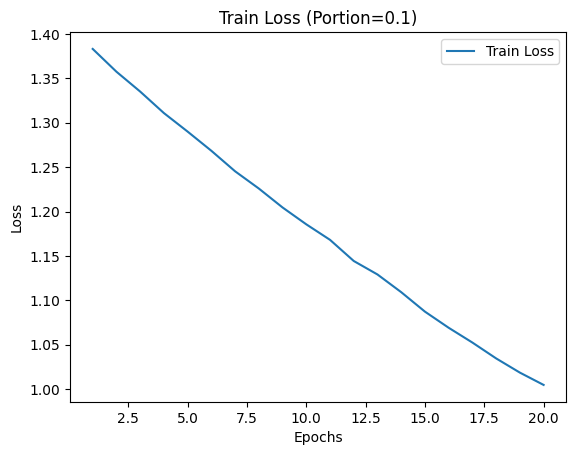

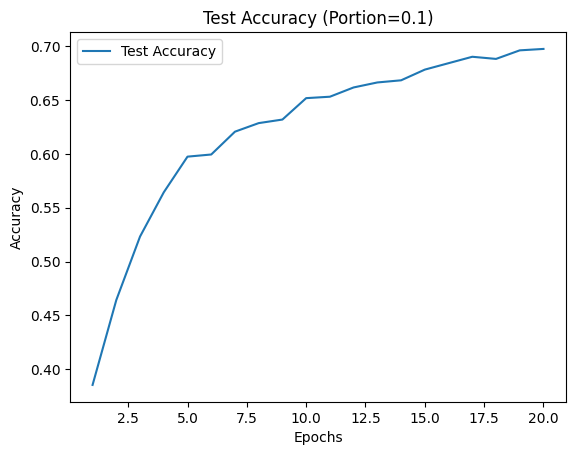

Running Single Layer MLP for Portion=0.2
model=MLPModel(
  (model): Sequential(
    (0): Linear(in_features=2000, out_features=4, bias=True)
  )
), parameters=8004


100%|██████████| 29/29 [00:00<00:00, 347.73it/s]



Epoch 1/20
Train Loss = 1.3747957533803479
Validation Accuracy = 0.39389920424403185


100%|██████████| 29/29 [00:00<00:00, 394.59it/s]



Epoch 2/20
Train Loss = 1.337182747906652
Validation Accuracy = 0.5842175066312998


100%|██████████| 29/29 [00:00<00:00, 465.79it/s]



Epoch 3/20
Train Loss = 1.3061877201343406
Validation Accuracy = 0.5557029177718833


100%|██████████| 29/29 [00:00<00:00, 445.76it/s]



Epoch 4/20
Train Loss = 1.270780324935913
Validation Accuracy = 0.5994694960212201


100%|██████████| 29/29 [00:00<00:00, 439.78it/s]



Epoch 5/20
Train Loss = 1.2391127389052818
Validation Accuracy = 0.6372679045092838


100%|██████████| 29/29 [00:00<00:00, 612.35it/s]



Epoch 6/20
Train Loss = 1.2089851683583752
Validation Accuracy = 0.666445623342175


100%|██████████| 29/29 [00:00<00:00, 538.24it/s]



Epoch 7/20
Train Loss = 1.1782741176670994
Validation Accuracy = 0.6750663129973474


100%|██████████| 29/29 [00:00<00:00, 440.52it/s]



Epoch 8/20
Train Loss = 1.1443417771109219
Validation Accuracy = 0.6923076923076923


100%|██████████| 29/29 [00:00<00:00, 471.28it/s]



Epoch 9/20
Train Loss = 1.1229658455684268
Validation Accuracy = 0.6836870026525199


100%|██████████| 29/29 [00:00<00:00, 535.53it/s]



Epoch 10/20
Train Loss = 1.0945948588437047
Validation Accuracy = 0.6896551724137931


100%|██████████| 29/29 [00:00<00:00, 518.46it/s]



Epoch 11/20
Train Loss = 1.0614425272777164
Validation Accuracy = 0.7108753315649867


100%|██████████| 29/29 [00:00<00:00, 508.63it/s]



Epoch 12/20
Train Loss = 1.0435398632082447
Validation Accuracy = 0.7082228116710876


100%|██████████| 29/29 [00:00<00:00, 511.66it/s]



Epoch 13/20
Train Loss = 1.0141500090730602
Validation Accuracy = 0.7175066312997348


100%|██████████| 29/29 [00:00<00:00, 469.42it/s]



Epoch 14/20
Train Loss = 0.994506416649654
Validation Accuracy = 0.7228116710875332


100%|██████████| 29/29 [00:00<00:00, 363.58it/s]



Epoch 15/20
Train Loss = 0.9691961613194696
Validation Accuracy = 0.7387267904509284


100%|██████████| 29/29 [00:00<00:00, 584.43it/s]



Epoch 16/20
Train Loss = 0.9433754785307522
Validation Accuracy = 0.7446949602122016


100%|██████████| 29/29 [00:00<00:00, 568.72it/s]



Epoch 17/20
Train Loss = 0.9301512344130154
Validation Accuracy = 0.746684350132626


100%|██████████| 29/29 [00:00<00:00, 586.54it/s]



Epoch 18/20
Train Loss = 0.903550581685428
Validation Accuracy = 0.7519893899204244


100%|██████████| 29/29 [00:00<00:00, 594.05it/s]



Epoch 19/20
Train Loss = 0.8804346651866518
Validation Accuracy = 0.7526525198938993


100%|██████████| 29/29 [00:00<00:00, 567.67it/s]



Epoch 20/20
Train Loss = 0.8673451131787794
Validation Accuracy = 0.7553050397877984


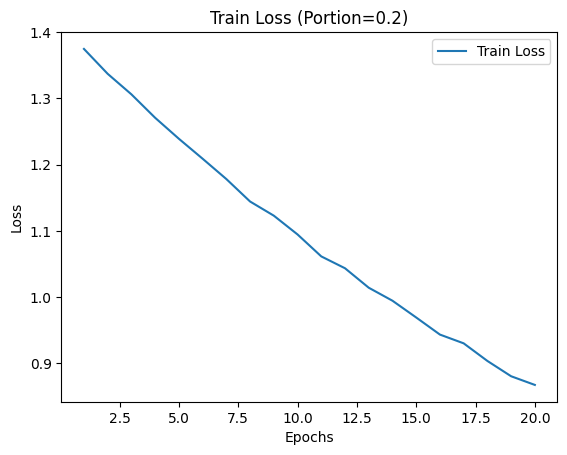

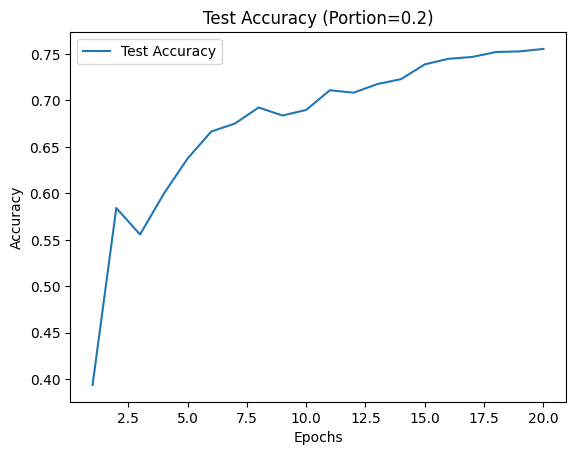

Running Single Layer MLP for Portion=0.5
model=MLPModel(
  (model): Sequential(
    (0): Linear(in_features=2000, out_features=4, bias=True)
  )
), parameters=8004


100%|██████████| 71/71 [00:00<00:00, 606.76it/s]



Epoch 1/20
Train Loss = 1.3592939175350565
Validation Accuracy = 0.7075596816976127


100%|██████████| 71/71 [00:00<00:00, 576.04it/s]



Epoch 2/20
Train Loss = 1.2929854409795412
Validation Accuracy = 0.730106100795756


100%|██████████| 71/71 [00:00<00:00, 582.63it/s]



Epoch 3/20
Train Loss = 1.2318943906837785
Validation Accuracy = 0.7519893899204244


100%|██████████| 71/71 [00:00<00:00, 619.76it/s]



Epoch 4/20
Train Loss = 1.173772049621797
Validation Accuracy = 0.7798408488063661


100%|██████████| 71/71 [00:00<00:00, 630.56it/s]



Epoch 5/20
Train Loss = 1.119550241550929
Validation Accuracy = 0.7970822281167109


100%|██████████| 71/71 [00:00<00:00, 620.84it/s]



Epoch 6/20
Train Loss = 1.0686531075289551
Validation Accuracy = 0.7977453580901857


100%|██████████| 71/71 [00:00<00:00, 557.56it/s]



Epoch 7/20
Train Loss = 1.0214127176244494
Validation Accuracy = 0.8043766578249337


100%|██████████| 71/71 [00:00<00:00, 645.34it/s]



Epoch 8/20
Train Loss = 0.9764259877339215
Validation Accuracy = 0.8163129973474801


100%|██████████| 71/71 [00:00<00:00, 582.82it/s]



Epoch 9/20
Train Loss = 0.9343661061474975
Validation Accuracy = 0.8163129973474801


100%|██████████| 71/71 [00:00<00:00, 606.24it/s]



Epoch 10/20
Train Loss = 0.89531160660193
Validation Accuracy = 0.8176392572944297


100%|██████████| 71/71 [00:00<00:00, 616.06it/s]



Epoch 11/20
Train Loss = 0.8583191213473468
Validation Accuracy = 0.8169761273209549


100%|██████████| 71/71 [00:00<00:00, 621.74it/s]



Epoch 12/20
Train Loss = 0.8237601459865839
Validation Accuracy = 0.8189655172413793


100%|██████████| 71/71 [00:00<00:00, 428.67it/s]



Epoch 13/20
Train Loss = 0.7920340383556527
Validation Accuracy = 0.8169761273209549


100%|██████████| 71/71 [00:00<00:00, 447.59it/s]



Epoch 14/20
Train Loss = 0.7617325312654737
Validation Accuracy = 0.8176392572944297


100%|██████████| 71/71 [00:00<00:00, 498.15it/s]



Epoch 15/20
Train Loss = 0.7327759601700474
Validation Accuracy = 0.8183023872679045


100%|██████████| 71/71 [00:00<00:00, 394.84it/s]



Epoch 16/20
Train Loss = 0.7066095043236101
Validation Accuracy = 0.8176392572944297


100%|██████████| 71/71 [00:00<00:00, 437.78it/s]



Epoch 17/20
Train Loss = 0.6814593823862748
Validation Accuracy = 0.8176392572944297


100%|██████████| 71/71 [00:00<00:00, 416.73it/s]



Epoch 18/20
Train Loss = 0.6568610668182373
Validation Accuracy = 0.8176392572944297


100%|██████████| 71/71 [00:00<00:00, 449.78it/s]



Epoch 19/20
Train Loss = 0.6348932095816437
Validation Accuracy = 0.8202917771883289


100%|██████████| 71/71 [00:00<00:00, 474.34it/s]



Epoch 20/20
Train Loss = 0.6135068942963238
Validation Accuracy = 0.8189655172413793


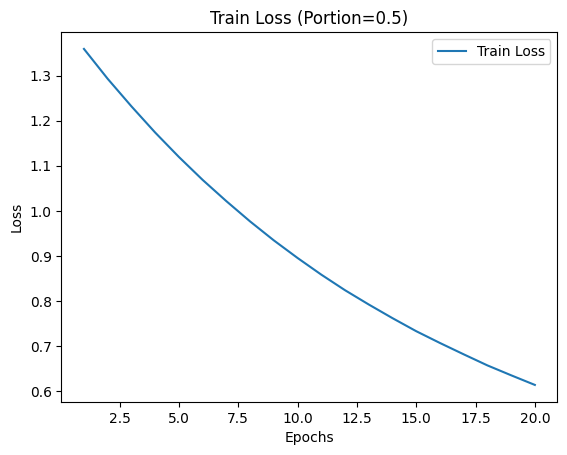

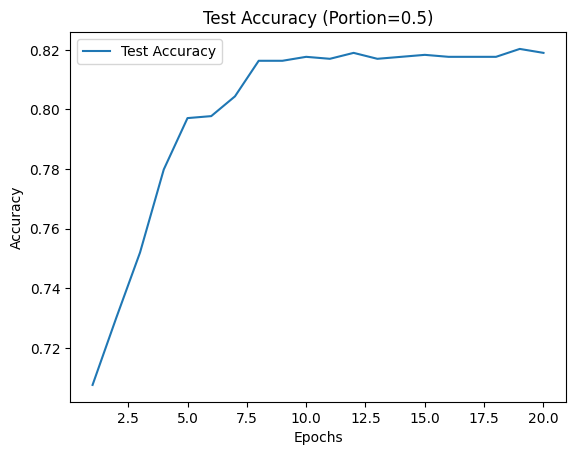

Running Single Layer MLP for Portion=1.0
model=MLPModel(
  (model): Sequential(
    (0): Linear(in_features=2000, out_features=4, bias=True)
  )
), parameters=8004


100%|██████████| 142/142 [00:00<00:00, 535.85it/s]



Epoch 1/20
Train Loss = 1.3349223271222181
Validation Accuracy = 0.7751989389920424


100%|██████████| 142/142 [00:00<00:00, 581.43it/s]



Epoch 2/20
Train Loss = 1.2260421371795762
Validation Accuracy = 0.8275862068965517


100%|██████████| 142/142 [00:00<00:00, 551.70it/s]



Epoch 3/20
Train Loss = 1.129048830186817
Validation Accuracy = 0.833554376657825


100%|██████████| 142/142 [00:00<00:00, 578.25it/s]



Epoch 4/20
Train Loss = 1.042925003128992
Validation Accuracy = 0.8368700265251989


100%|██████████| 142/142 [00:00<00:00, 587.73it/s]



Epoch 5/20
Train Loss = 0.9669183639573379
Validation Accuracy = 0.8421750663129973


100%|██████████| 142/142 [00:00<00:00, 545.69it/s]



Epoch 6/20
Train Loss = 0.8992158233279913
Validation Accuracy = 0.8408488063660478


100%|██████████| 142/142 [00:00<00:00, 593.77it/s]



Epoch 7/20
Train Loss = 0.8394298754947286
Validation Accuracy = 0.8421750663129973


100%|██████████| 142/142 [00:00<00:00, 558.24it/s]



Epoch 8/20
Train Loss = 0.7864001905414421
Validation Accuracy = 0.8415119363395226


100%|██████████| 142/142 [00:00<00:00, 553.14it/s]



Epoch 9/20
Train Loss = 0.7390267525760221
Validation Accuracy = 0.8415119363395226


100%|██████████| 142/142 [00:00<00:00, 573.54it/s]



Epoch 10/20
Train Loss = 0.696417638953303
Validation Accuracy = 0.8448275862068966


100%|██████████| 142/142 [00:00<00:00, 599.27it/s]



Epoch 11/20
Train Loss = 0.6584583520889282
Validation Accuracy = 0.8448275862068966


100%|██████████| 142/142 [00:00<00:00, 570.72it/s]



Epoch 12/20
Train Loss = 0.6238306160544006
Validation Accuracy = 0.8474801061007957


100%|██████████| 142/142 [00:00<00:00, 556.38it/s]



Epoch 13/20
Train Loss = 0.5927353157124049
Validation Accuracy = 0.8481432360742706


100%|██████████| 142/142 [00:00<00:00, 581.64it/s]



Epoch 14/20
Train Loss = 0.5643773853359088
Validation Accuracy = 0.8488063660477454


100%|██████████| 142/142 [00:00<00:00, 582.73it/s]



Epoch 15/20
Train Loss = 0.5384371633261023
Validation Accuracy = 0.8494694960212201


100%|██████████| 142/142 [00:00<00:00, 524.36it/s]



Epoch 16/20
Train Loss = 0.5143482689286621
Validation Accuracy = 0.8481432360742706


100%|██████████| 142/142 [00:00<00:00, 601.79it/s]



Epoch 17/20
Train Loss = 0.4917962740004902
Validation Accuracy = 0.8514588859416445


100%|██████████| 142/142 [00:00<00:00, 595.27it/s]



Epoch 18/20
Train Loss = 0.47183143211082673
Validation Accuracy = 0.8507957559681698


100%|██████████| 142/142 [00:00<00:00, 451.40it/s]



Epoch 19/20
Train Loss = 0.4525971851298507
Validation Accuracy = 0.850132625994695


100%|██████████| 142/142 [00:00<00:00, 516.33it/s]



Epoch 20/20
Train Loss = 0.4348640128130644
Validation Accuracy = 0.8514588859416445


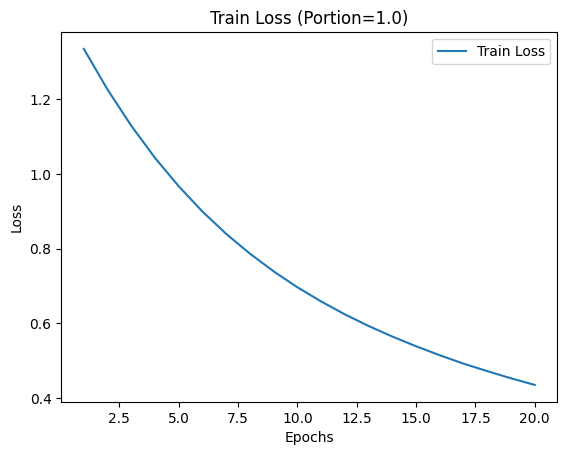

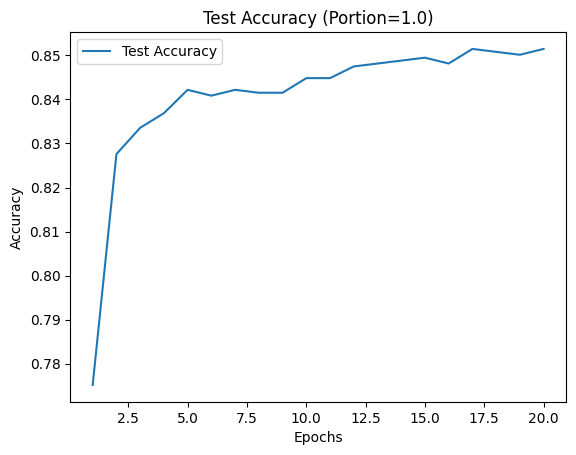


Multi-layer MLP results:
Running Multi Layer MLP for Portion=0.1
model=MLPModel(
  (model): Sequential(
    (0): Linear(in_features=2000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=4, bias=True)
  )
), parameters=1002504


100%|██████████| 15/15 [00:00<00:00, 379.22it/s]



Epoch 1/20
Train Loss = 1.3768983602523803
Validation Accuracy = 0.6359416445623343


100%|██████████| 15/15 [00:00<00:00, 390.34it/s]



Epoch 2/20
Train Loss = 1.2653040329615275
Validation Accuracy = 0.7261273209549072


100%|██████████| 15/15 [00:00<00:00, 400.52it/s]



Epoch 3/20
Train Loss = 1.0416261752446492
Validation Accuracy = 0.7327586206896551


100%|██████████| 15/15 [00:00<00:00, 426.50it/s]



Epoch 4/20
Train Loss = 0.7157101631164551
Validation Accuracy = 0.7513262599469496


100%|██████████| 15/15 [00:00<00:00, 425.36it/s]



Epoch 5/20
Train Loss = 0.40831164121627805
Validation Accuracy = 0.7546419098143236


100%|██████████| 15/15 [00:00<00:00, 435.04it/s]



Epoch 6/20
Train Loss = 0.21539422074953715
Validation Accuracy = 0.7526525198938993


100%|██████████| 15/15 [00:00<00:00, 423.62it/s]



Epoch 7/20
Train Loss = 0.1194354181488355
Validation Accuracy = 0.7513262599469496


100%|██████████| 15/15 [00:00<00:00, 353.80it/s]



Epoch 8/20
Train Loss = 0.07590147356192271
Validation Accuracy = 0.7486737400530504


100%|██████████| 15/15 [00:00<00:00, 422.82it/s]



Epoch 9/20
Train Loss = 0.0491010420024395
Validation Accuracy = 0.75


100%|██████████| 15/15 [00:00<00:00, 423.14it/s]



Epoch 10/20
Train Loss = 0.037085485210021335
Validation Accuracy = 0.7453580901856764


100%|██████████| 15/15 [00:00<00:00, 429.73it/s]



Epoch 11/20
Train Loss = 0.02826580243806044
Validation Accuracy = 0.7453580901856764


100%|██████████| 15/15 [00:00<00:00, 437.78it/s]



Epoch 12/20
Train Loss = 0.024250891432166098
Validation Accuracy = 0.743368700265252


100%|██████████| 15/15 [00:00<00:00, 433.85it/s]



Epoch 13/20
Train Loss = 0.019786371911565463
Validation Accuracy = 0.743368700265252


100%|██████████| 15/15 [00:00<00:00, 416.40it/s]



Epoch 14/20
Train Loss = 0.016870626031110683
Validation Accuracy = 0.7440318302387268


100%|██████████| 15/15 [00:00<00:00, 352.59it/s]



Epoch 15/20
Train Loss = 0.015194662163654964
Validation Accuracy = 0.7387267904509284


100%|██████████| 15/15 [00:00<00:00, 367.76it/s]



Epoch 16/20
Train Loss = 0.013103709431986015
Validation Accuracy = 0.7393899204244032


100%|██████████| 15/15 [00:00<00:00, 430.70it/s]



Epoch 17/20
Train Loss = 0.011601877259090542
Validation Accuracy = 0.7374005305039788


100%|██████████| 15/15 [00:00<00:00, 312.79it/s]



Epoch 18/20
Train Loss = 0.010900515659401814
Validation Accuracy = 0.736737400530504


100%|██████████| 15/15 [00:00<00:00, 447.22it/s]



Epoch 19/20
Train Loss = 0.009551999593774478
Validation Accuracy = 0.7354111405835544


100%|██████████| 15/15 [00:00<00:00, 408.71it/s]



Epoch 20/20
Train Loss = 0.008613216263862947
Validation Accuracy = 0.7340848806366048


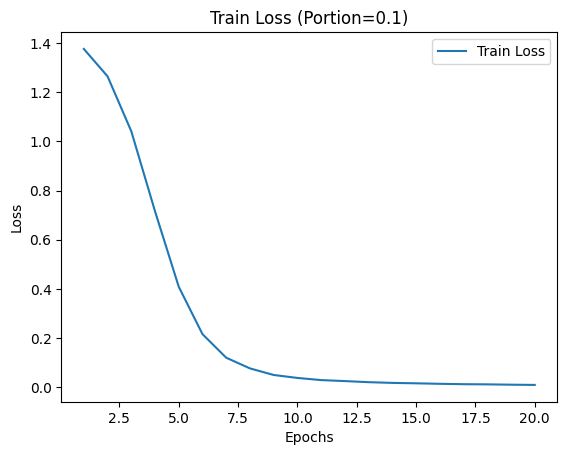

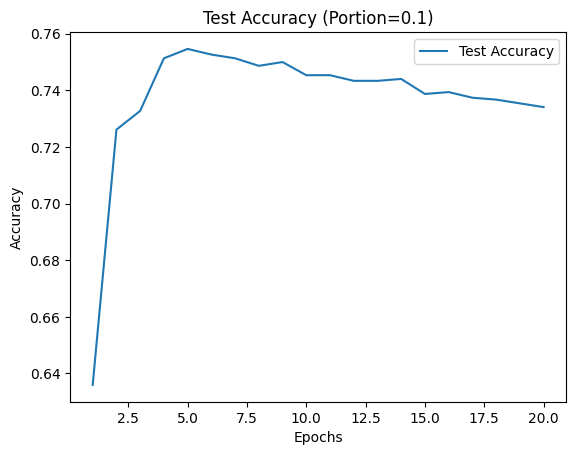

Running Multi Layer MLP for Portion=0.2
model=MLPModel(
  (model): Sequential(
    (0): Linear(in_features=2000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=4, bias=True)
  )
), parameters=1002504


100%|██████████| 29/29 [00:00<00:00, 447.31it/s]



Epoch 1/20
Train Loss = 1.3501967931615895
Validation Accuracy = 0.6438992042440318


100%|██████████| 29/29 [00:00<00:00, 464.19it/s]



Epoch 2/20
Train Loss = 1.0511649929243942
Validation Accuracy = 0.7725464190981433


100%|██████████| 29/29 [00:00<00:00, 475.61it/s]



Epoch 3/20
Train Loss = 0.5394523678154781
Validation Accuracy = 0.8003978779840849


100%|██████████| 29/29 [00:00<00:00, 423.53it/s]



Epoch 4/20
Train Loss = 0.2407178382935195
Validation Accuracy = 0.8076923076923077


100%|██████████| 29/29 [00:00<00:00, 503.89it/s]



Epoch 5/20
Train Loss = 0.10767212709219291
Validation Accuracy = 0.7984084880636605


100%|██████████| 29/29 [00:00<00:00, 411.75it/s]



Epoch 6/20
Train Loss = 0.060997638979862476
Validation Accuracy = 0.8057029177718833


100%|██████████| 29/29 [00:00<00:00, 349.73it/s]



Epoch 7/20
Train Loss = 0.040754975943729795
Validation Accuracy = 0.8023872679045093


100%|██████████| 29/29 [00:00<00:00, 411.31it/s]



Epoch 8/20
Train Loss = 0.029121299017349195
Validation Accuracy = 0.8010610079575596


100%|██████████| 29/29 [00:00<00:00, 357.28it/s]



Epoch 9/20
Train Loss = 0.022590591941542667
Validation Accuracy = 0.8010610079575596


100%|██████████| 29/29 [00:00<00:00, 316.13it/s]



Epoch 10/20
Train Loss = 0.018394850836745625
Validation Accuracy = 0.7997347480106101


100%|██████████| 29/29 [00:00<00:00, 360.78it/s]



Epoch 11/20
Train Loss = 0.01588031814979582
Validation Accuracy = 0.7964190981432361


100%|██████████| 29/29 [00:00<00:00, 389.02it/s]



Epoch 12/20
Train Loss = 0.013709492379285652
Validation Accuracy = 0.7964190981432361


100%|██████████| 29/29 [00:00<00:00, 371.02it/s]



Epoch 13/20
Train Loss = 0.012400926411922636
Validation Accuracy = 0.7944297082228117


100%|██████████| 29/29 [00:00<00:00, 404.51it/s]



Epoch 14/20
Train Loss = 0.010880067450765135
Validation Accuracy = 0.7937665782493368


100%|██████████| 29/29 [00:00<00:00, 433.52it/s]



Epoch 15/20
Train Loss = 0.009866389096714556
Validation Accuracy = 0.7897877984084881


100%|██████████| 29/29 [00:00<00:00, 334.57it/s]



Epoch 16/20
Train Loss = 0.009092980325382588
Validation Accuracy = 0.7877984084880637


100%|██████████| 29/29 [00:00<00:00, 343.37it/s]



Epoch 17/20
Train Loss = 0.008439974257208663
Validation Accuracy = 0.7858090185676393


100%|██████████| 29/29 [00:00<00:00, 431.40it/s]



Epoch 18/20
Train Loss = 0.007798424825586122
Validation Accuracy = 0.786472148541114


100%|██████████| 29/29 [00:00<00:00, 316.64it/s]



Epoch 19/20
Train Loss = 0.007426017220934917
Validation Accuracy = 0.7858090185676393


100%|██████████| 29/29 [00:00<00:00, 363.34it/s]



Epoch 20/20
Train Loss = 0.006846314229890062
Validation Accuracy = 0.7851458885941645


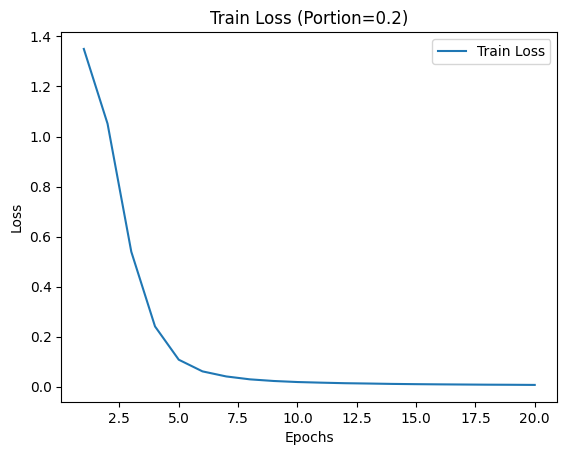

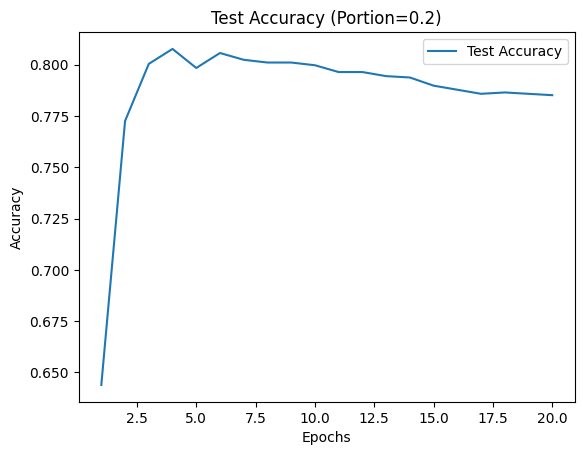

Running Multi Layer MLP for Portion=0.5
model=MLPModel(
  (model): Sequential(
    (0): Linear(in_features=2000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=4, bias=True)
  )
), parameters=1002504


100%|██████████| 71/71 [00:00<00:00, 456.27it/s]



Epoch 1/20
Train Loss = 1.1760216002732935
Validation Accuracy = 0.7931034482758621


100%|██████████| 71/71 [00:00<00:00, 463.47it/s]



Epoch 2/20
Train Loss = 0.45216675921225213
Validation Accuracy = 0.8249336870026526


100%|██████████| 71/71 [00:00<00:00, 454.49it/s]



Epoch 3/20
Train Loss = 0.16525712210527607
Validation Accuracy = 0.8262599469496021


100%|██████████| 71/71 [00:00<00:00, 497.91it/s]



Epoch 4/20
Train Loss = 0.08013336777582135
Validation Accuracy = 0.8309018567639257


100%|██████████| 71/71 [00:00<00:00, 455.46it/s]



Epoch 5/20
Train Loss = 0.04558769303938033
Validation Accuracy = 0.8255968169761273


100%|██████████| 71/71 [00:00<00:00, 481.29it/s]



Epoch 6/20
Train Loss = 0.029634524530298273
Validation Accuracy = 0.8262599469496021


100%|██████████| 71/71 [00:00<00:00, 457.08it/s]



Epoch 7/20
Train Loss = 0.022575894567433377
Validation Accuracy = 0.8242705570291777


100%|██████████| 71/71 [00:00<00:00, 475.83it/s]



Epoch 8/20
Train Loss = 0.01834258945776858
Validation Accuracy = 0.8242705570291777


100%|██████████| 71/71 [00:00<00:00, 491.62it/s]



Epoch 9/20
Train Loss = 0.015993507460914026
Validation Accuracy = 0.8216180371352785


100%|██████████| 71/71 [00:00<00:00, 473.42it/s]



Epoch 10/20
Train Loss = 0.014321688546235082
Validation Accuracy = 0.8236074270557029


100%|██████████| 71/71 [00:00<00:00, 462.06it/s]



Epoch 11/20
Train Loss = 0.013321644064157047
Validation Accuracy = 0.8216180371352785


100%|██████████| 71/71 [00:00<00:00, 446.47it/s]



Epoch 12/20
Train Loss = 0.012683558285164214
Validation Accuracy = 0.8202917771883289


100%|██████████| 71/71 [00:00<00:00, 461.41it/s]



Epoch 13/20
Train Loss = 0.012041747502812093
Validation Accuracy = 0.8236074270557029


100%|██████████| 71/71 [00:00<00:00, 481.11it/s]



Epoch 14/20
Train Loss = 0.011693109990209078
Validation Accuracy = 0.8222811671087533


100%|██████████| 71/71 [00:00<00:00, 467.47it/s]



Epoch 15/20
Train Loss = 0.01156127998239728
Validation Accuracy = 0.8216180371352785


100%|██████████| 71/71 [00:00<00:00, 409.22it/s]



Epoch 16/20
Train Loss = 0.01130926121160729
Validation Accuracy = 0.8202917771883289


100%|██████████| 71/71 [00:00<00:00, 507.24it/s]



Epoch 17/20
Train Loss = 0.010975646768765472
Validation Accuracy = 0.8176392572944297


100%|██████████| 71/71 [00:00<00:00, 517.19it/s]



Epoch 18/20
Train Loss = 0.011193301199532022
Validation Accuracy = 0.8222811671087533


100%|██████████| 71/71 [00:00<00:00, 477.44it/s]



Epoch 19/20
Train Loss = 0.010866191531252772
Validation Accuracy = 0.8183023872679045


100%|██████████| 71/71 [00:00<00:00, 446.80it/s]



Epoch 20/20
Train Loss = 0.011088163002261328
Validation Accuracy = 0.8183023872679045


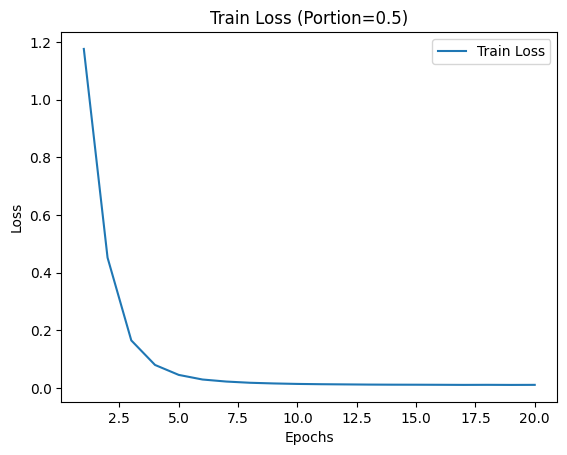

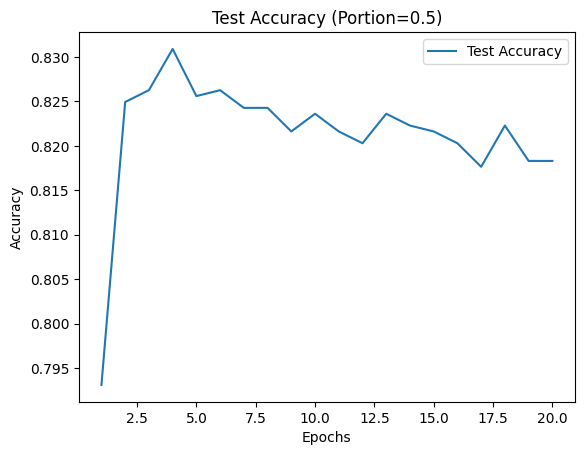

Running Multi Layer MLP for Portion=1.0
model=MLPModel(
  (model): Sequential(
    (0): Linear(in_features=2000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=4, bias=True)
  )
), parameters=1002504


100%|██████████| 142/142 [00:00<00:00, 467.38it/s]



Epoch 1/20
Train Loss = 0.8710535905310806
Validation Accuracy = 0.8527851458885941


100%|██████████| 142/142 [00:00<00:00, 502.38it/s]



Epoch 2/20
Train Loss = 0.22887832414306386
Validation Accuracy = 0.8547745358090185


100%|██████████| 142/142 [00:00<00:00, 487.67it/s]



Epoch 3/20
Train Loss = 0.09842727543182776
Validation Accuracy = 0.8461538461538461


100%|██████████| 142/142 [00:00<00:00, 459.38it/s]



Epoch 4/20
Train Loss = 0.05201276701966852
Validation Accuracy = 0.8441644562334217


100%|██████████| 142/142 [00:00<00:00, 478.05it/s]



Epoch 5/20
Train Loss = 0.033724470250964374
Validation Accuracy = 0.843501326259947


100%|██████████| 142/142 [00:00<00:00, 484.23it/s]



Epoch 6/20
Train Loss = 0.025170669949967677
Validation Accuracy = 0.8388594164456233


100%|██████████| 142/142 [00:00<00:00, 473.51it/s]



Epoch 7/20
Train Loss = 0.02128824589013214
Validation Accuracy = 0.8401856763925729


100%|██████████| 142/142 [00:00<00:00, 484.15it/s]



Epoch 8/20
Train Loss = 0.01861608549206465
Validation Accuracy = 0.8401856763925729


100%|██████████| 142/142 [00:00<00:00, 460.96it/s]



Epoch 9/20
Train Loss = 0.017229674389941656
Validation Accuracy = 0.8368700265251989


100%|██████████| 142/142 [00:00<00:00, 476.52it/s]



Epoch 10/20
Train Loss = 0.016852114441834102
Validation Accuracy = 0.8395225464190982


100%|██████████| 142/142 [00:00<00:00, 501.66it/s]



Epoch 11/20
Train Loss = 0.01629357867399526
Validation Accuracy = 0.8388594164456233


100%|██████████| 142/142 [00:00<00:00, 481.01it/s]



Epoch 12/20
Train Loss = 0.015856760776393496
Validation Accuracy = 0.8388594164456233


100%|██████████| 142/142 [00:00<00:00, 309.69it/s]



Epoch 13/20
Train Loss = 0.015485090702037576
Validation Accuracy = 0.8395225464190982


100%|██████████| 142/142 [00:00<00:00, 320.77it/s]



Epoch 14/20
Train Loss = 0.01552841980651785
Validation Accuracy = 0.8375331564986738


100%|██████████| 142/142 [00:00<00:00, 500.93it/s]



Epoch 15/20
Train Loss = 0.015319033186706677
Validation Accuracy = 0.8322281167108754


100%|██████████| 142/142 [00:00<00:00, 477.84it/s]



Epoch 16/20
Train Loss = 0.015056391816344817
Validation Accuracy = 0.8362068965517241


100%|██████████| 142/142 [00:00<00:00, 473.06it/s]



Epoch 17/20
Train Loss = 0.014964947752444677
Validation Accuracy = 0.8355437665782494


100%|██████████| 142/142 [00:00<00:00, 473.67it/s]



Epoch 18/20
Train Loss = 0.014969915302079013
Validation Accuracy = 0.8388594164456233


100%|██████████| 142/142 [00:00<00:00, 413.53it/s]



Epoch 19/20
Train Loss = 0.014864145203933782
Validation Accuracy = 0.8381962864721485


100%|██████████| 142/142 [00:00<00:00, 409.52it/s]



Epoch 20/20
Train Loss = 0.01495303868273688
Validation Accuracy = 0.8401856763925729


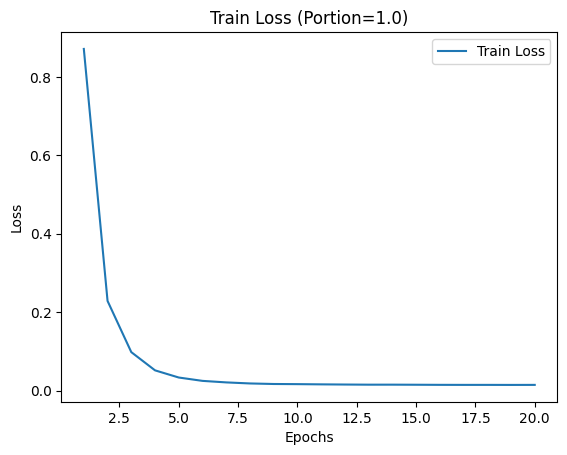

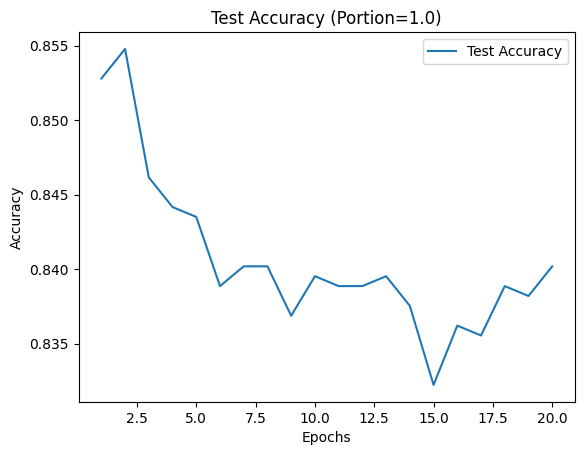


Transformer results:
Portion: 0.1


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model=RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
     

100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Train Loss: 1.1856


100%|██████████| 95/95 [00:22<00:00,  4.22it/s]


Validation Accuracy: 0.7149
Epoch 2/3


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Train Loss: 0.4795


100%|██████████| 95/95 [00:21<00:00,  4.32it/s]


Validation Accuracy: 0.8660
Epoch 3/3


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Train Loss: 0.2716


100%|██████████| 95/95 [00:22<00:00,  4.16it/s]


Validation Accuracy: 0.8707


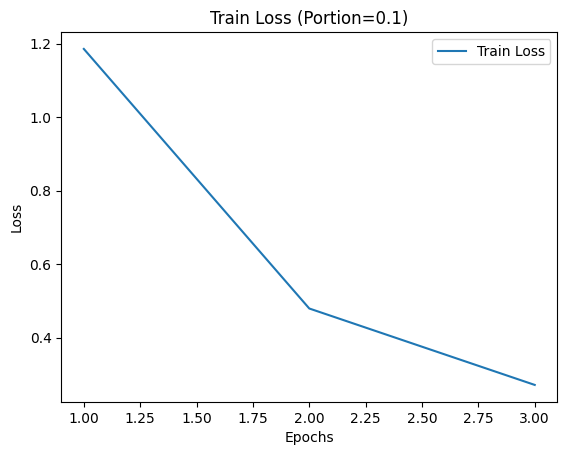

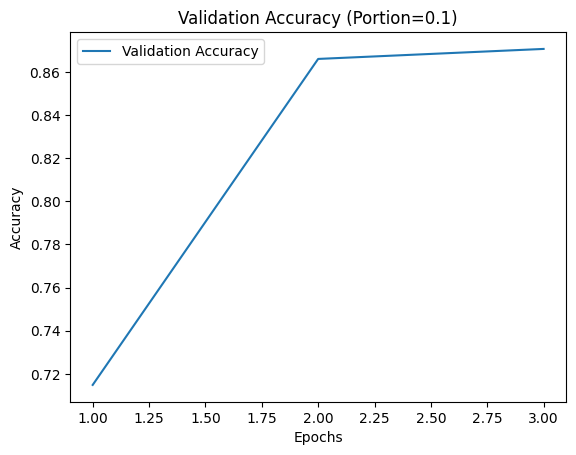

Portion: 0.2


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model=RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
     

100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Train Loss: 1.0168


100%|██████████| 95/95 [00:22<00:00,  4.14it/s]


Validation Accuracy: 0.8495
Epoch 2/3


100%|██████████| 29/29 [00:21<00:00,  1.32it/s]


Train Loss: 0.3675


100%|██████████| 95/95 [00:22<00:00,  4.21it/s]


Validation Accuracy: 0.8727
Epoch 3/3


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Train Loss: 0.2154


100%|██████████| 95/95 [00:22<00:00,  4.16it/s]


Validation Accuracy: 0.8760


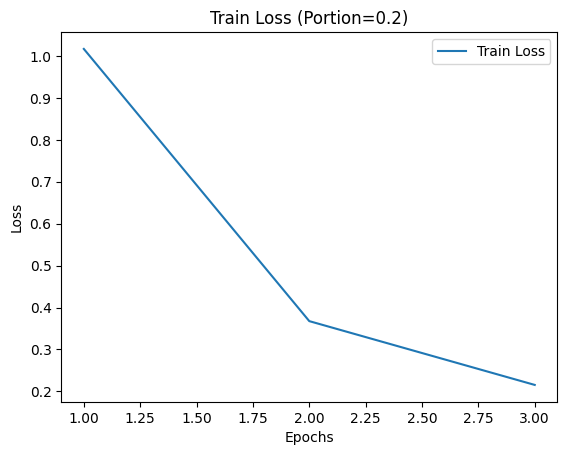

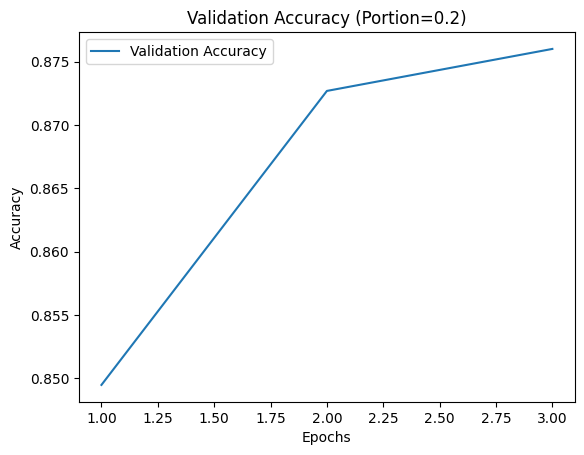

In [22]:
if __name__ == "__main__":
    portions = [0.1, 0.2, 0.5, 1.]
    # Q1 - single layer MLP
    print("\nSingle Layer MLP results:")
    for portion in portions:
        print(f"Running Single Layer MLP for Portion={portion}")
        MLP_classification(portion=portion, model="single")


    # Q2 - multi-layer MLP
    print("\nMulti-layer MLP results:")
    for portion in portions:
        print(f"Running Multi Layer MLP for Portion={portion}")
        MLP_classification(portion=portion, model="multi")

    # Q3 - Transformer
    print("\nTransformer results:")
    for p in portions[:2]:
        print(f"Portion: {p}")
        transformer_classification(portion=p)